In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.optim import SGD
from torchvision import models, transforms
import PIL
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import scipy.ndimage as ndimage

%matplotlib inline

import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO


def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def showtensor(a):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    showarray(inp)
    clear_output(wait=True)

def plot_images(im, titles=None):
    plt.figure(figsize=(30, 20))

    for i in range(len(im)):
        plt.subplot(10 / 5 + 1, 5, i + 1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(im[i])

    plt.pause(0.001)

normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def init_image(size=(400, 400, 3)):
    img = PIL.Image.fromarray(np.uint8(np.full(size, 150)))
    img = PIL.Image.fromarray(np.uint8(np.random.uniform(150, 180, size)))
    img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def load_image(path, resize=False, size=None):
    img = PIL.Image.open(path)

    if size is not None:
        img.thumbnail(size, PIL.Image.ANTIALIAS)

    if resize:
        img_tensor = normalise_resize(img).unsqueeze(0)
    else:
        img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def tensor_to_img(t):
    a = t.numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    inp = np.uint8(np.clip(inp, 0, 255))
    return PIL.Image.fromarray(inp)

def image_to_variable(image, requires_grad=False, cuda=False):
    if cuda:
        image = Variable(image.cuda(), requires_grad=requires_grad)
    else:
        image = Variable(image, requires_grad=requires_grad)
    return image

In [2]:
# prompt: load a pretrained vgg16

model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 86.9MB/s]


In [3]:
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True

print(model)

for param in model.parameters():
    param.requires_grad = False

if use_gpu:
    print("Using CUDA")
    model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
def octaver_fn(model, base_img, step_fn, octave_n=6, octave_scale=1.4, iter_n=10, **step_args):
    octaves = [base_img]#list of octaves with base image as the first argument

    for i in range(octave_n - 1):#number of octaves that are to be applied
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])#Initializes a detail image with zeros, having the same shape as the last octave image in octaves list
    for octave, octave_base in enumerate(octaves[::-1]):#octaves list is reversed and then enumerated
        h, w = octave_base.shape[-2:]#second last and last element in the shape of the enumerating object

        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)#resize detail image

        src = octave_base + detail

        for i in range(iter_n):
            src = step_fn(model, src, **step_args)

        detail = src.numpy() - octave_base#modified image - current base , no more zeros

    return src

In [19]:
def objective(dst, guide_features):#return the objective image we need for further operations
    if guide_features is None:
        return dst.data
    else:
        x = dst.data[0].cpu().numpy()
        y = guide_features.data[0].cpu().numpy()
        ch, w, h = x.shape
        x = x.reshape(ch, -1)
        y = y.reshape(ch, -1)
        A = x.T.dot(y)
        diff = y[:, A.argmax(1)]
        diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])).cuda()
        return diff

def make_step(model, img, objective=objective, control=None, step_size=1.5, end=28, jitter=32):
    global use_gpu

    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])

    #introducing a randomness in picture to avoid local minimas
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    img = np.roll(np.roll(img, ox, -1), oy, -2)

    #preparing for grad ascent
    tensor = torch.Tensor(img)
    img_var = image_to_variable(tensor, requires_grad=True, cuda=use_gpu)
    model.zero_grad()

    #Forward Pass through the Model
    x = img_var
    for index, layer in enumerate(model.features.children()):
        x = layer(x)
        if index == end:
            break

    delta = objective(x, control)
    x.backward(delta)#we calc loss wrt a custom objective function

    #L2 Regularization on gradients
    mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2)])
    if use_gpu:
        mean_square = mean_square.cuda()
    img_var.grad.data /= torch.sqrt(mean_square)#scaling
    img_var.data.add_(img_var.grad.data * step_size)#updating image

    result = img_var.data.cpu().numpy()
    result = np.roll(np.roll(result, -ox, -1), -oy, -2)#reverse jitter effect
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)#clipping
    showtensor(result)

    return torch.Tensor(result)

def deepdream(model, base_img, octave_n=6, octave_scale=1.4,
              iter_n=10, end=28, control=None, objective=objective,
              step_size=1.5, jitter=32):

    return octaver_fn(
              model, base_img, step_fn=make_step,
              octave_n=octave_n, octave_scale=octave_scale,
              iter_n=iter_n, end=end, control=control,
              objective=objective, step_size=step_size, jitter=jitter
           )

<ipython-input-1-51b637e692f7>:73: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(size, PIL.Image.ANTIALIAS)


(1024, 768)


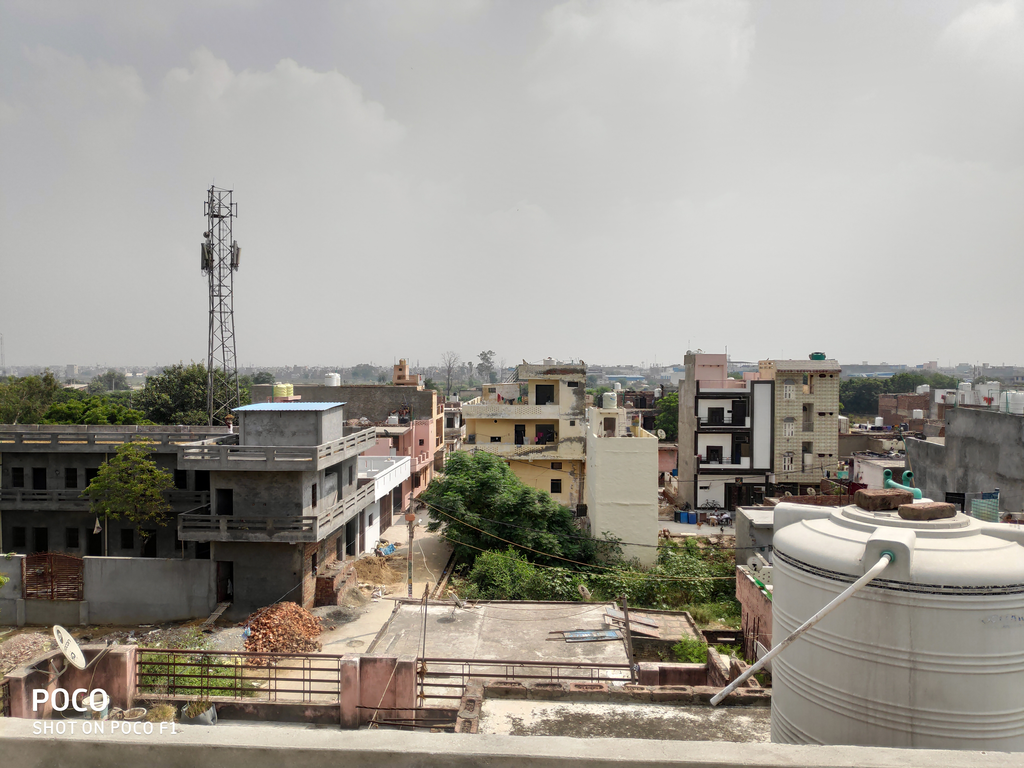

In [20]:
input_img, input_tensor, input_np = load_image('/content/IMG_20190925_111041.jpg', size=[1024, 1024])
print(input_img.size)
input_img

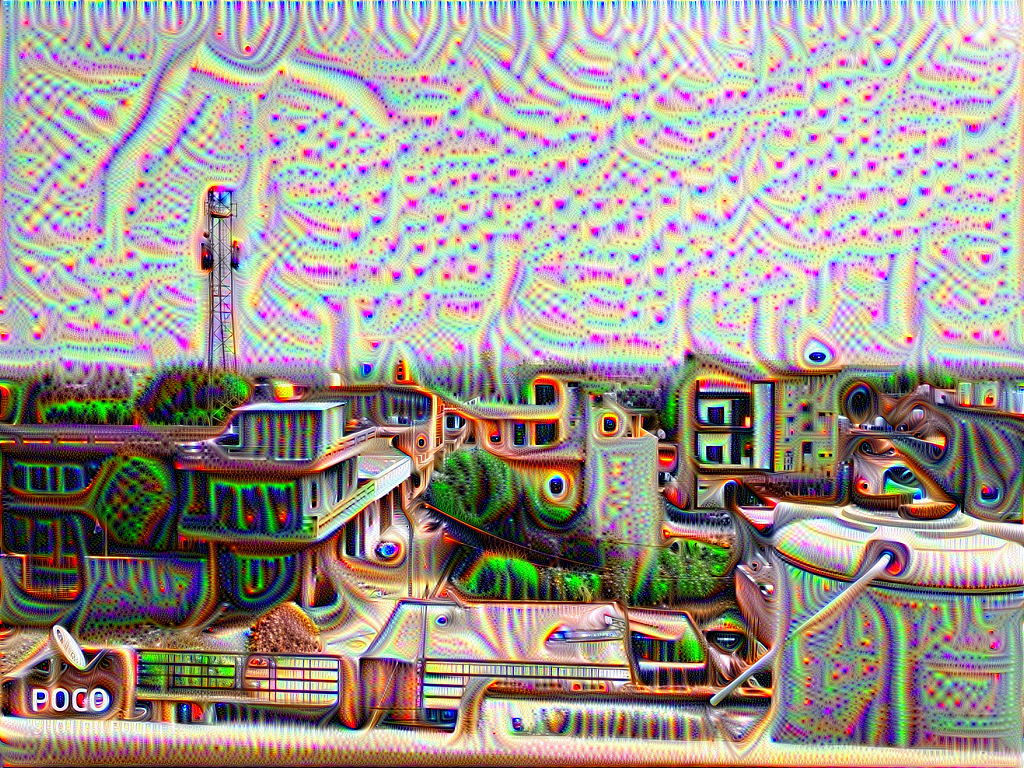

In [21]:
dream = deepdream(model, input_np, end=14, step_size=0.06, octave_n=6)
dream = tensor_to_img(dream)
dream.save('dream00.jpg')
dream

guiding deep dream


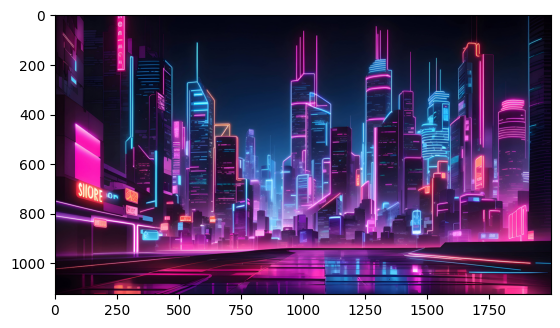

In [70]:
guide_img, guide_img_tensor, guide_img_np = load_image('/content/AdobeStock_624499925.jpg', resize=True)
plt.imshow(guide_img)

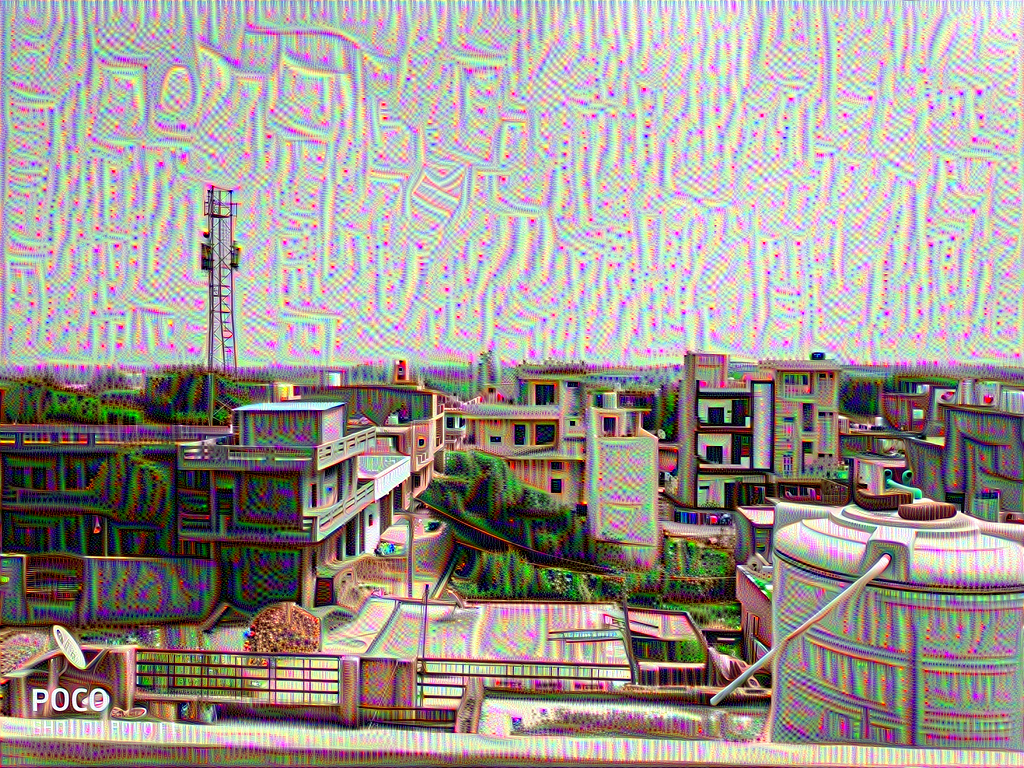

In [71]:
end = 14

guide_features = image_to_variable(guide_img_tensor, cuda=use_gpu)

for index, layer in enumerate(model.features.children()):
    guide_features = layer(guide_features)
    if index == end:
        break

dream = deepdream(model, input_np, end=end, step_size=0.06, octave_n=4, control=guide_features)
dream = tensor_to_img(dream)
dream.save('dream04.jpg')
dream